# Langgraph Basics

## Required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai python-dotenv

## Set API keys

These keys are stored in the `.env` file.

In [2]:
import os

%load_ext dotenv
%dotenv

os.environ.get("OPENAI_API_KEY");

# Optionally, we can set API keys like this:
# os.environ["OPENAI_API_KEY"] = "your_key"

## StateGraph and State

`StateGraph` is a class that represents the graph. We initialize this class by passing in a `state` definition. This `state` definition represents a central state object that is updated over time. This `state` is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store).

The attributes of this `state` can be updated in two ways. First, an attribute could be overridden completely. This is useful if we want to nodes to return the new value of an attribute. Second, an attribute could be updated by adding to its value. This is useful if an attribute is a list of actions taken (or something similar) and we want nodes to return new actions taken (and have those automatically added to the attribute).

`Annotated` in python allows developers to declare the type of a reference and provide additional information related to it. Here, 
messages have the type `list`. The `add_messages` function in the annotation defines how this state key should be updated (in this case, it appends messages to the list, rather than overwriting them).

We specify whether an attribute should be **overridden** (default) or **added** to when creating the initial state definition (`add_messages` is for our chatbot; `operator.add` is used in the [LangGraph Docs](https://blog.langchain.dev/langgraph/) by LangChain).

In [3]:
from typing import Annotated

from typing_extensions import TypedDict 

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph = StateGraph(State)

## Node

After creating a `StateGraph`, we then add nodes with `graph.add_node(name, value)` syntax. The name parameter should be a string that we will use to refer to the node when adding edges. The value parameter should be either a function or LCEL runnable that will be called. This function/LCEL should accept a dictionary in the same form as the State object as **input**, and **output** a dictionary with keys of the State object to update.

Here, we're adding a node called **"chatbot"** that takes the `chatbot` function.

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph.add_node("chatbot", chatbot)

## Edge

After adding nodes, we can then add edges to create the graph. Edges connect nodes together. There are a few types of edges.

### The Starting and Ending Edge

This is the edge that connects the **start of the graph** to a **particular node**, aka the `entry_point`. This will make it so that that node is the first one called when input is passed to the graph.

In [5]:
graph.set_entry_point("chatbot")

This is the edge that connects a **paticular node** to the **end of the graph**, aka the `finish_point`.

In [6]:
graph.set_finish_point("chatbot")

Another way the set the above egdes:

In [ ]:
# from langgraph.graph import START, END
# graph.add_edge(START, "chatbot")
# graph.add_edge("chatbot", END)

### Normal Edges

These are edges where one node should **ALWAYS** be called after another. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. Since our agent only have 1 node "chatbot", here is an example from the [LangGraph Docs](https://blog.langchain.dev/langgraph/) by LangChain.

In [ ]:
# graph.add_edge("tools", "model")

### Conditional Edges

These are where a function (often powered by an LLM) is used to determine which node to go to first. To create this edge, we need to pass in three things:

1. **The upstream node:** the output of this node will be looked at to determine what to do next.
2. **A function:** this will be called to determine which node to call next. It should return a string.
3. **A mapping:** this mapping will be used to map the output of the function in (2) to another node. The keys should be possible values that the function in (2) could return. The values should be names of nodes to go to if that value is returned.

An example of this could be that after a model is called we either exit the graph and return to the user, or we call a tool - depending on what a user decides!

In [ ]:
# graph.add_conditional_edge(
#     "model",
#     should_continue,
#     {
#         "end": END,
#         "continue": "tools"
#     }
# )

## Compile

After we define our graph, we can compile it into a runnable! This simply takes the graph definition we've created so far an returns a runnable. This runnable exposes all the same method as LangChain runnables (`.invoke`, `.stream`, `.astream_log`, etc) allowing it to be called in the same manner as a chain.

In [7]:
app = graph.compile()

## Visualize

We can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

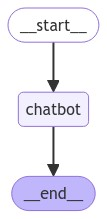

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run the chatbot

In [10]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in app.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Langgraph is a language learning platform that uses artificial intelligence to help users improve their language skills through interactive exercises, personalized lessons, and real-time feedback. It offers courses in various languages and adapts to each user's individual learning style and pace.
Goodbye!


# Tavily Search Tool

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

## Required packages

In [1]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

## Set API Keys

Set your [TAVILY_API_KEY](https://tavily.com/).

In [3]:
import os

%load_ext dotenv
%dotenv

os.environ.get("OPENAI_API_KEY");
os.environ.get("TAVILY_API_KEY");

# Optionally, we can set API keys like this:
# os.environ["OPENAI_API_KEY"] = "your_key"
# os.environ["TAVILY_API_KEY"] = "your_key"

## Define the Tool

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
# define tools as a list of tool objects
tools = [tool]

#example
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://medium.com/@bhavikjikadara/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383',
  'content': 'LangGraph is a library for building stateful, multi-actor applications with LLMs. ... We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a ...'}]

## Define the Graph

We have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [10]:
from typing import Annotated

from langchain_openai import ChatOpenAI

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [11]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear.

In [13]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "tools": "tools", 
        "__end__": "__end__"
    },
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph.add_edge("tools", "chatbot")
graph.add_edge(START, "chatbot")
app = graph.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the `chatbot` node runs, either go to `tools` if it calls a tool, or end the loop if it responds directly".

Like the prebuilt `tools_condition`, our function returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

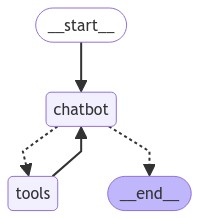

In [16]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

In [19]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in app.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: 
Assistant: [{"url": "https://www.timeanddate.com/", "content": "Find the current time in any city or country around the world, and compare time zones with a map and a converter. Learn about time zone changes, DST, holidays, events, and more."}, {"url": "https://www.epochconverter.com/daynumbers", "content": "Find out what is the current day number based on ISO-8601 ordinal date format and learn how to calculate it in various programming languages. See examples, lists and explanations of day numbers by year and leap years."}]
Assistant: I found some relevant search results, but they don't directly provide the current day. Let me try another approach to find the current day for you.
Assistant: [{"url": "https://www.calculator.net/day-of-the-week-calculator.html", "content": "The internationally recognized method of conveying the day of the week is governed by ISO 8601, which uses an algorithm for calculating the day of a week in a

# Memory 

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is *much* more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `SqliteSaver` checkpointer.

In [20]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")